# Core Packages, Seed, Palette

In [1]:
library(ggplot2)
library(tidyverse)
library(caret)
library(gt)
library(Rtsne)

#library()

set.seed(42)
palette_name <- "Red-Green"
class_colors <- hcl.colors(n = 2, palette = palette_name)
class_colors_grad <- hcl.colors(n = 10, palette = palette_name)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




# Load Data

In [2]:
df_dating <- read.csv("./cleanedData/data_clean.csv",stringsAsFactors = TRUE)
data.frame( Instances = nrow(df_dating), Features = ncol(df_dating))

Instances,Features
<int>,<int>
6949,34


In [3]:
str(df_dating)

'data.frame':	6949 obs. of  34 variables:
 $ gender            : Factor w/ 2 levels "female","male": 1 1 1 1 1 1 1 1 1 1 ...
 $ d_age             : int  6 1 1 2 3 4 9 6 7 3 ...
 $ race              : Factor w/ 5 levels "Asian/Pacific Islander/Asian-American",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ samerace          : int  0 0 1 0 0 0 0 0 0 0 ...
 $ race_o            : Factor w/ 6 levels "?","Asian/Pacific Islander/Asian-American",..: 4 4 2 4 5 4 4 4 4 4 ...
 $ attractive_o      : num  6 7 10 7 8 7 3 6 7 6 ...
 $ sinsere_o         : num  8 8 10 8 7 7 6 7 7 6 ...
 $ intelligence_o    : num  8 10 10 9 9 8 7 5 8 6 ...
 $ funny_o           : num  8 7 10 8 6 8 5 6 8 6 ...
 $ ambitous_o        : num  8 7 10 9 9 7 8 8 8 6 ...
 $ shared_interests_o: num  6 5 10 8 7 7 7 6 9 6 ...
 $ attractive        : int  6 6 6 6 6 6 6 6 6 6 ...
 $ sincere           : int  8 8 8 8 8 8 8 8 8 8 ...
 $ intelligence      : int  8 8 8 8 8 8 8 8 8 8 ...
 $ funny             : int  8 8 8 8 8 8 8 8 8 8 ...
 $ ambition         

### Data type adjustments

In [4]:
df_dating$decision <- factor(df_dating$decision_o)
df_dating$decision_o <- NULL
df_dating$samerace <- factor(df_dating$samerace)

In [5]:
feature_types <- tibble(
  Numeric = sum(sapply(df_dating, is.numeric)),
  Factor  = sum(sapply(df_dating, is.factor))
)
feature_types |> as.data.frame() 

Numeric,Factor
<int>,<int>
29,5


# Inspect Data

## Class Balance

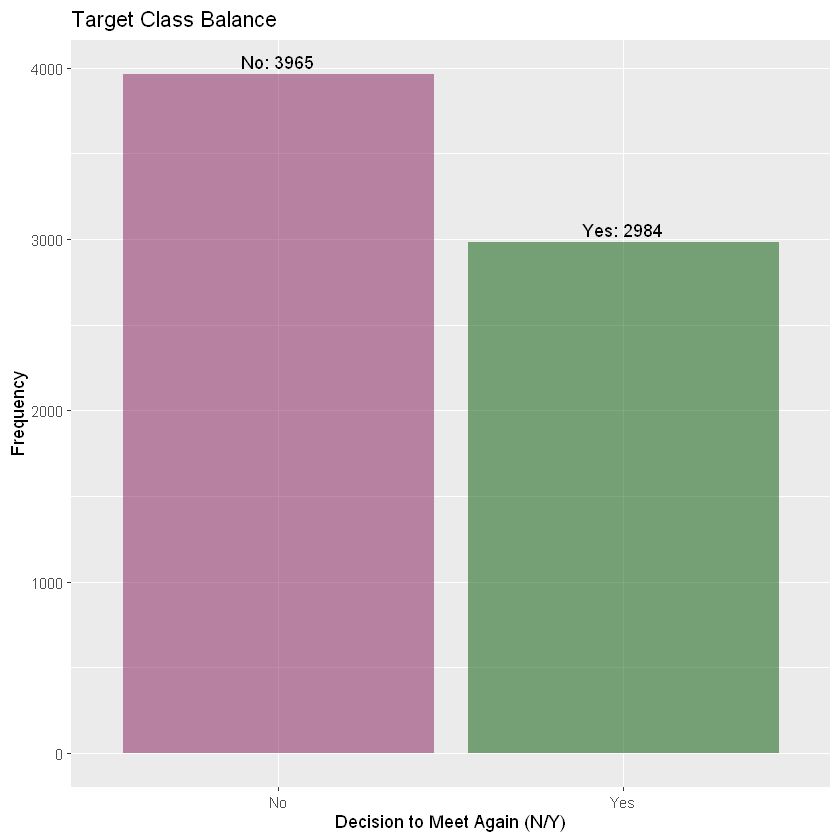

In [6]:
class_counts <- df_dating |> count(decision)
ggplot(class_counts,aes(x= decision,y=n)) +
    geom_col(show.legend = FALSE, fill=class_colors, alpha=0.5) +
    labs(title = "Target Class Balance", x = "Decision to Meet Again (N/Y)", y = "Frequency") +
    geom_text(aes(label = paste(c("No","Yes"),n,sep = ": ")),vjust=-.4) +
    scale_x_discrete(breaks=c("0","1"),labels = c("No","Yes"))

# Data Distribution

## Numeric Distribution by Feature Subcategory

In [7]:
plot_kde_grid <- function(feat_subset,subset_name, data=df_dating){
    data[c(feat_subset,"decision")] |>
        pivot_longer(cols = -decision, names_to = "Feature", values_to = "Value") |>
        ggplot(aes(x = Value,fill=decision)) +
            geom_density(adjust = 1.5,alpha = 0.4) +
            facet_wrap(~ Feature, ncol = length(feat_subset) %/% 2+1) +
            labs(
            title = paste(subset_name,"Distribution by Partner Decision"),
            x = "Feature Value",
            y = "Density"
            ) +
            theme_minimal(base_size = 15) +
            theme(legend.position = "bottom") +
            scale_fill_manual(values = class_colors)
        
}

In [8]:
plot_box_grid <- function(feat_subset,subset_name, data=df_dating){
    data[c(feat_subset,"decision")] |>
        pivot_longer(cols = -decision, names_to = "Feature", values_to = "Value") |>
        ggplot(aes(y = Value,fill=decision)) +
            geom_boxplot(alpha = 0.5,linewidth=1) +
            facet_wrap(~ Feature, ncol = max(c(length(feat_subset) %/% 2),1)) +
            labs(
            title = paste(subset_name,"Distribution by Partner Decision"),
            x = "Feature Name",
            y = "Density"
            ) +
            theme_minimal(base_size = 15) +
            theme(legend.position = "bottom", axis.text.x = element_blank()) +
            scale_fill_manual(values = class_colors, labels = c("No","Yes"))
                
}

In [9]:
names(df_dating)

[1] "gender"             "d_age"              "race"              
 [4] "samerace"           "race_o"             "attractive_o"      
 [7] "sinsere_o"          "intelligence_o"     "funny_o"           
[10] "ambitous_o"         "shared_interests_o" "attractive"        
[13] "sincere"            "intelligence"       "funny"             
[16] "ambition"           "sports"             "tvsports"          
[19] "exercise"           "dining"             "museums"           
[22] "art"                "hiking"             "gaming"            
[25] "clubbing"           "reading"            "tv"                
[28] "theater"            "movies"             "concerts"          
[31] "music"              "shopping"           "yoga"              
[34] "decision"

In [10]:
partner_self_ratings <- c("attractive_o", "sinsere_o", "intelligence_o", "funny_o", "ambitous_o", "shared_interests_o")
subject_self_ratings <- c("attractive","sincere","intelligence","funny","ambition")
interests<- c("sports","tvsports","exercise","dining","museums","art","hiking","gaming","clubbing","reading","tv","theater","movies","concerts","music","shopping","yoga")

---

In [11]:
partner_self_ratings %in% names(df_dating)

[1] TRUE TRUE TRUE TRUE TRUE TRUE

### By Subject Characteristics

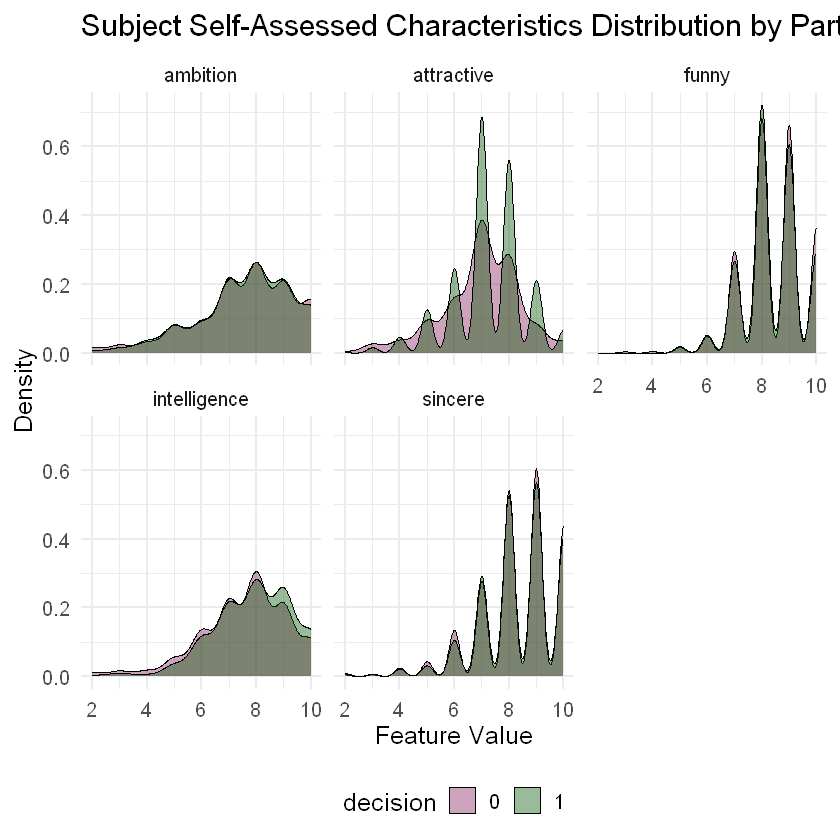

In [12]:
plot_kde_grid(subject_self_ratings,"Subject Self-Assessed Characteristics")

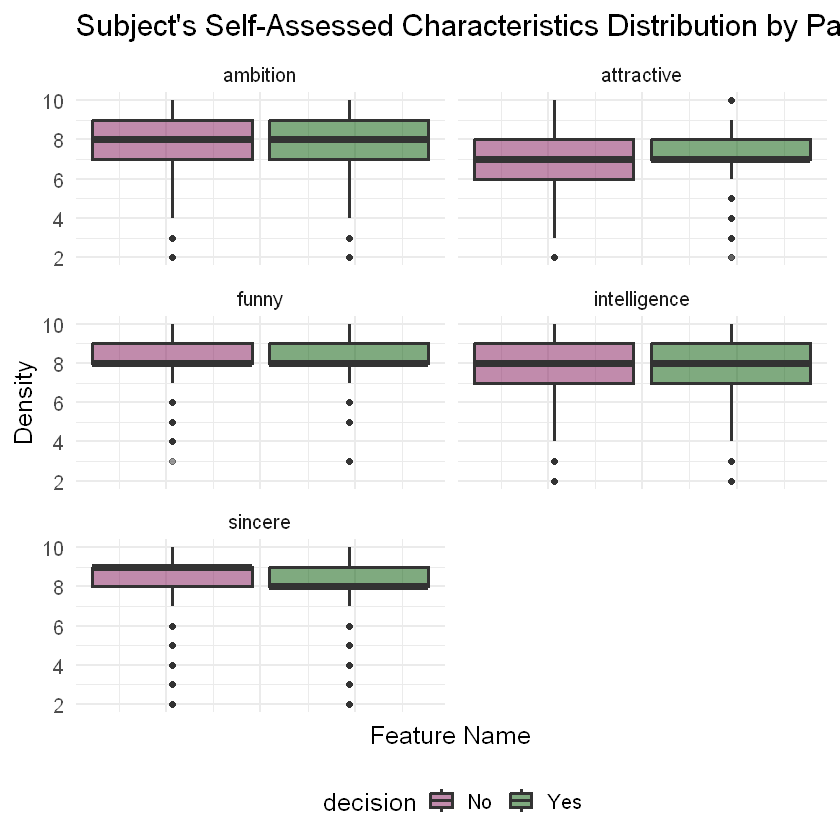

In [13]:
plot_box_grid(subject_self_ratings,"Subject's Self-Assessed Characteristics")

Green Flags -> Attractiveness, Intel

Red flag -> Funny

---

### By Partner Characteristics

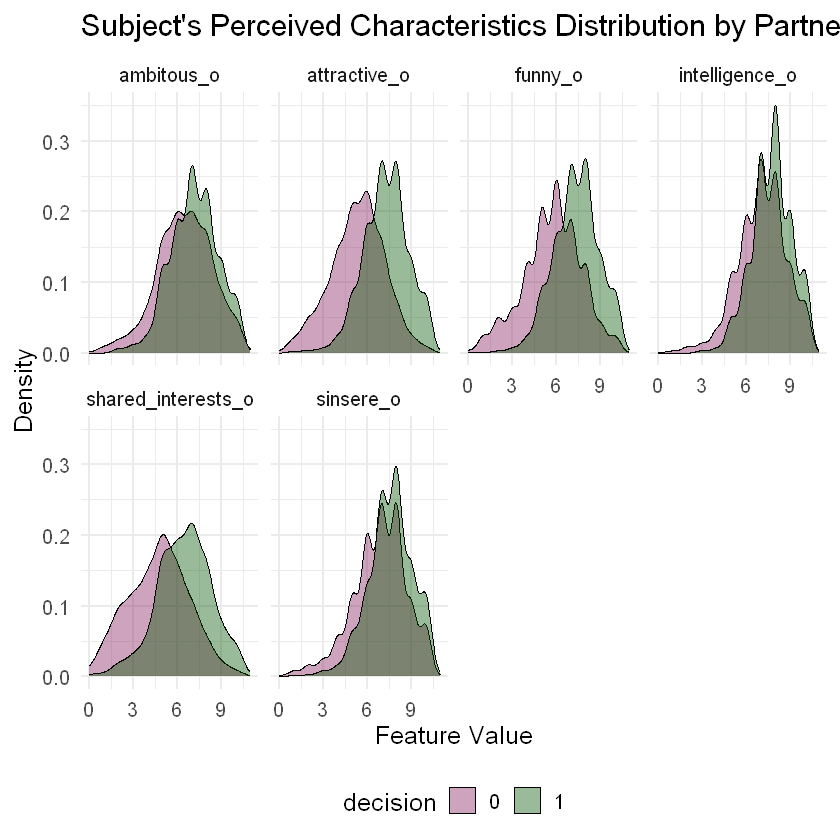

In [14]:
plot_kde_grid(partner_self_ratings,"Subject's Perceived Characteristics")

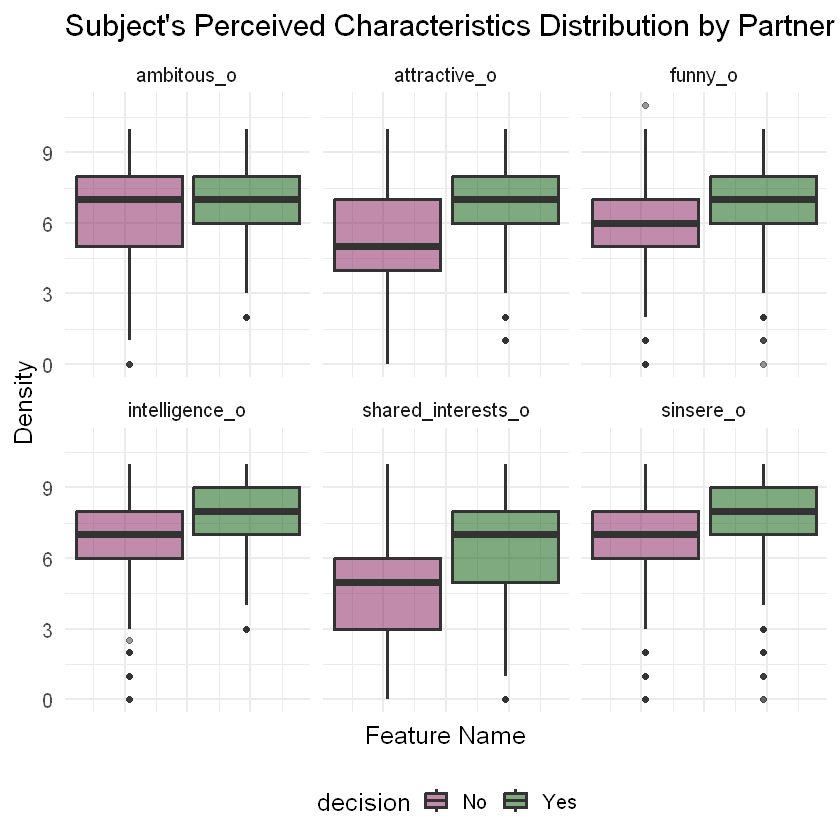

In [15]:
plot_box_grid(partner_self_ratings,"Subject's Perceived Characteristics")

---

### By Subject Interests

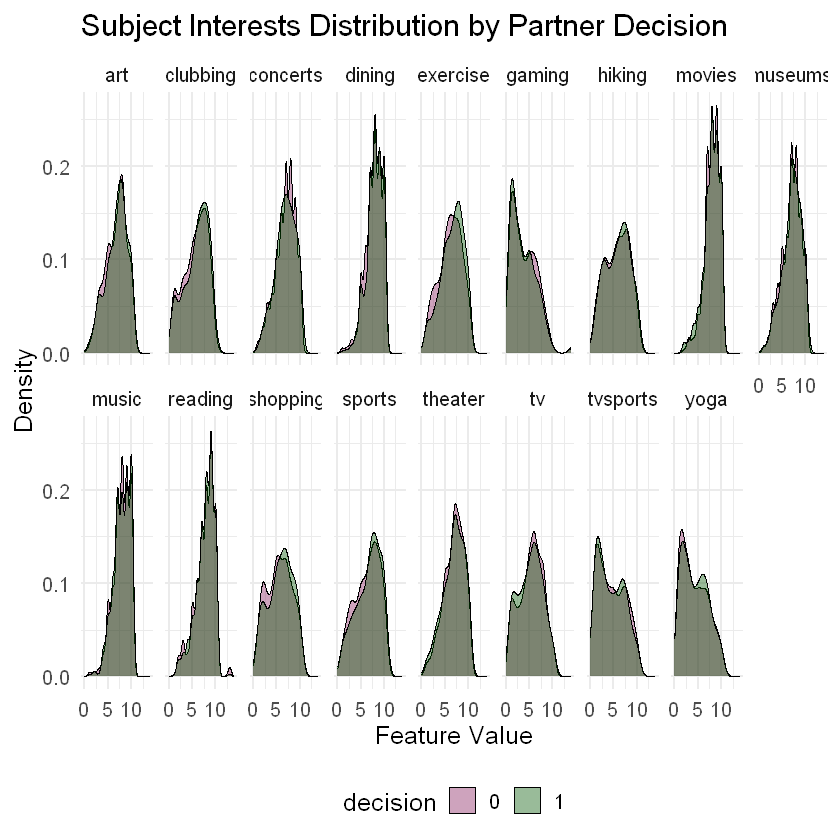

In [16]:
plot_kde_grid(interests,"Subject Interests")

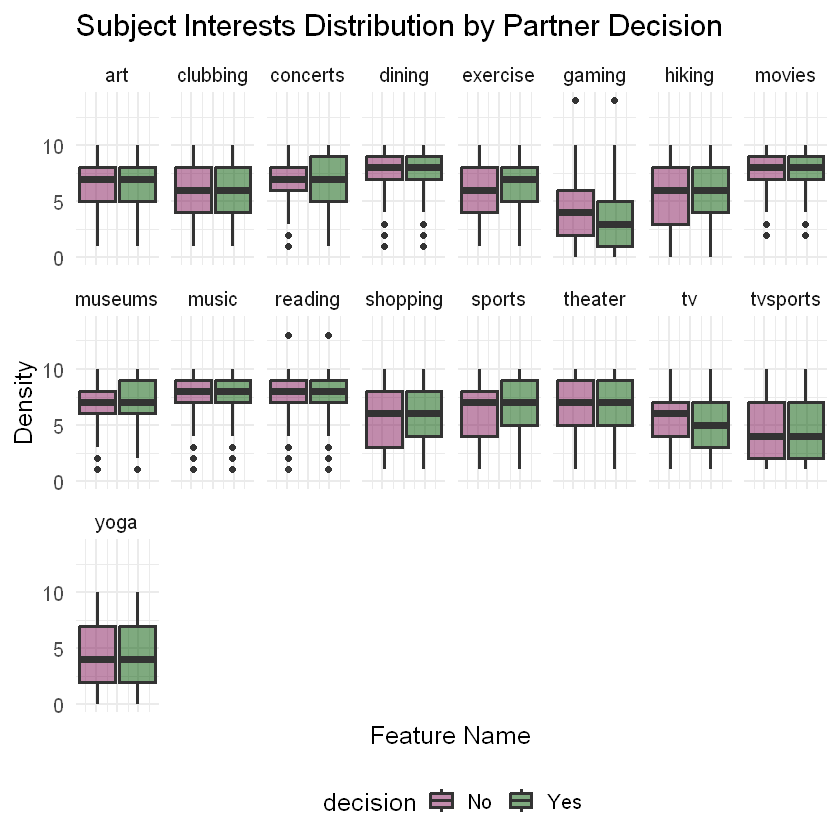

In [17]:
plot_box_grid(interests,"Subject Interests")

Green flags -> Physical hobbies (Sports, yoga,hiking, exercise), Clubbing -> 
red flags -> Concerts, gaming(?)

---

## Inspect Categorical Factor Features

In [18]:
plot_bar_grid <- function(subset,subset_name){
    df_dating[c(subset,"decision")] |>
        pivot_longer(cols = -decision, names_to = "Feature", values_to = "Value") |>
            ggplot(aes(x = Value,fill=decision)) +
                geom_bar(alpha = 0.4) +
                facet_wrap(~ Feature, ncol = length(subset) %/% 2+1) +
                labs(
                title = paste(subset_name,"Distribution by Partner Decision"),
                x = "Value",
                y = "Density"
                ) +
                theme_minimal(base_size = 15) +
                theme(legend.position = "bottom") +
        scale_fill_manual(values = class_colors)
        
}

In [19]:
plot_categorical_distributions <- function(data, cat_vars, fill_var, plot_title) {
  # select cats
  plot_data <- data |>
    select(all_of(cat_vars), all_of(fill_var)) |>
    pivot_longer(
      cols = all_of(cat_vars),
      names_to = "Variable",
      values_to = "Category"
    )

  # bar chart
  ggplot(plot_data, aes(x = Category, fill = .data[[fill_var]])) +
    geom_bar(position = "dodge", alpha =0.5) +
    facet_wrap(~ Variable, scales = "free_x") +
    labs(
      title = paste("Distribution of", plot_title,"Categorical Variables by Decision"),
      x = "Category",
      y = "Count"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_manual(values = class_colors)
}

### By Ethnographics 

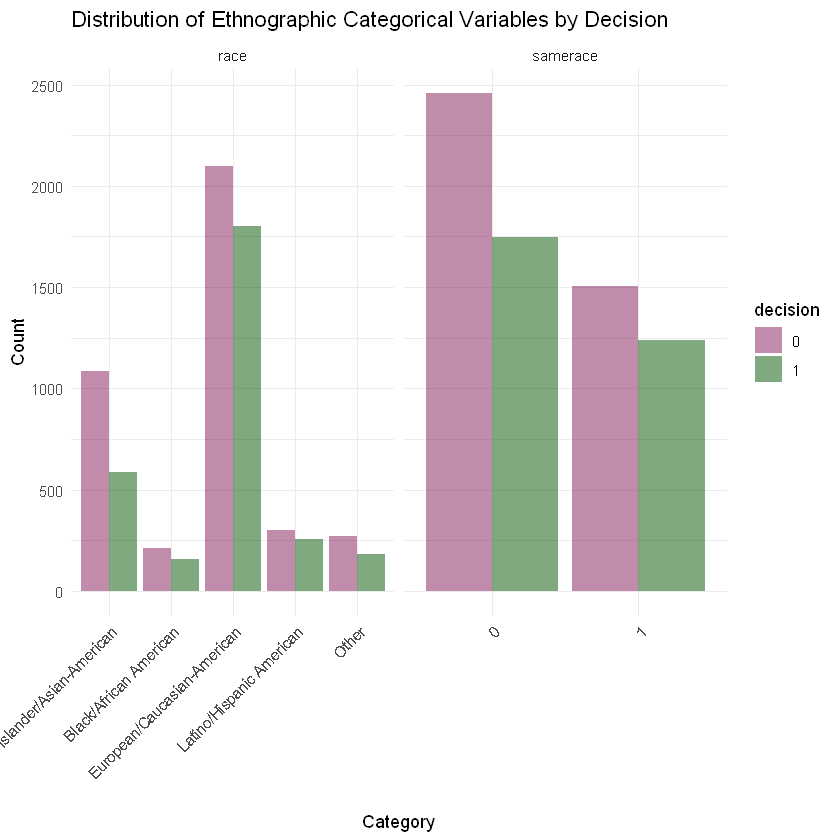

In [20]:
plot_categorical_distributions(df_dating,c("race","samerace"),"decision", "Ethnographic")

### By Gender

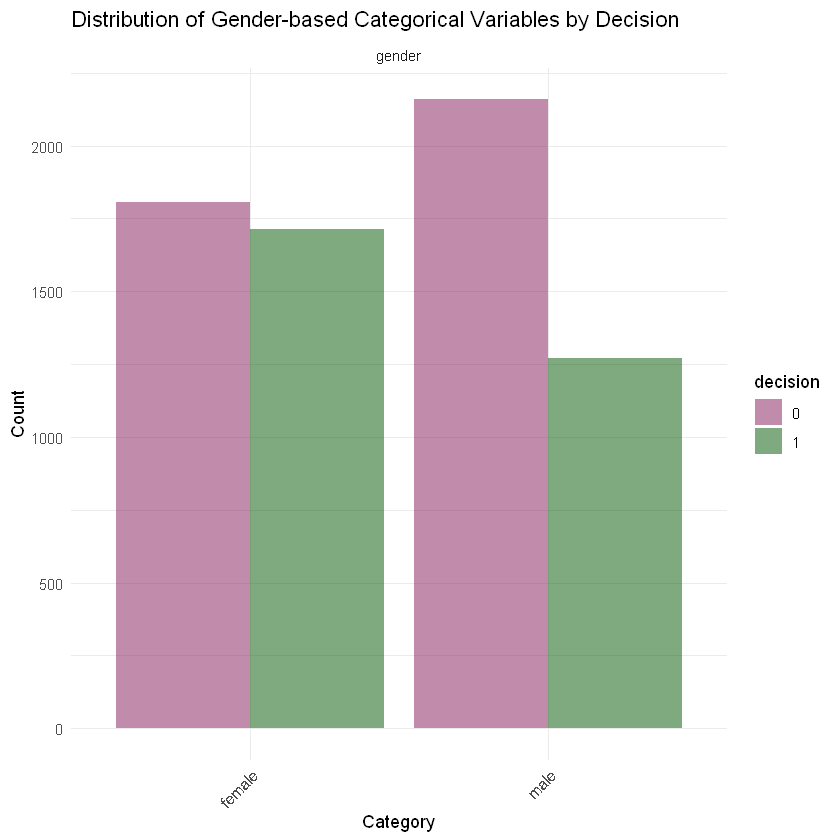

In [21]:
plot_categorical_distributions(df_dating,c("gender"),"decision", "Gender-based")

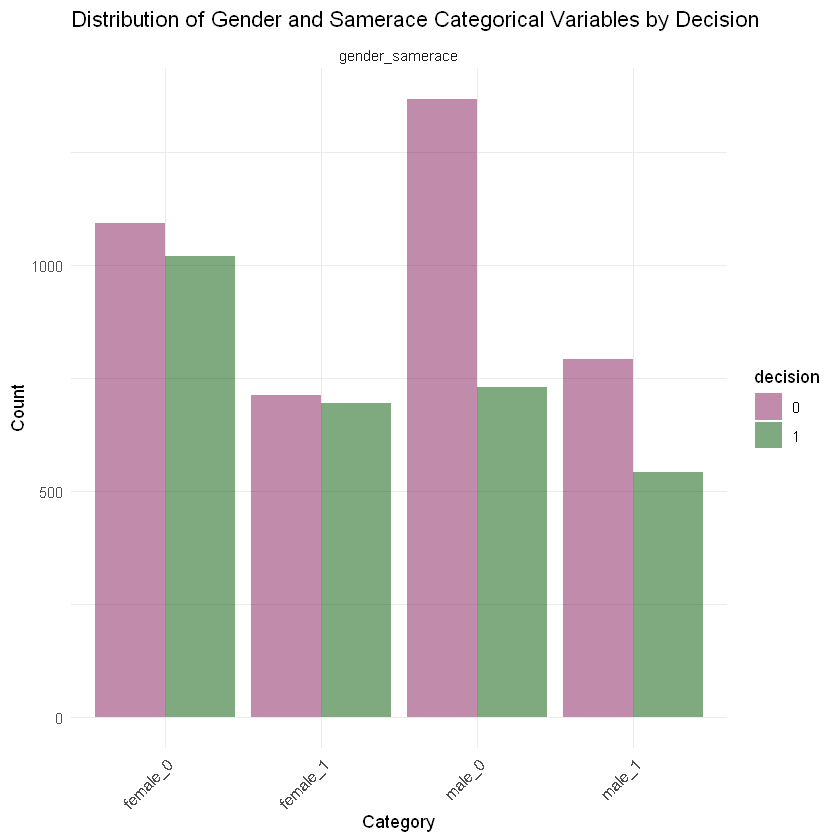

In [24]:
df_dating |>
    mutate(samerace = as.character(samerace)) |> 
    unite(
        col = "gender_samerace",
        c("gender", "samerace"),
        sep = "_"
    ) |>
    plot_categorical_distributions(
        cat_vars = "gender_samerace",
        fill_var = "decision",
        plot_title = "Gender and Samerace"
    )

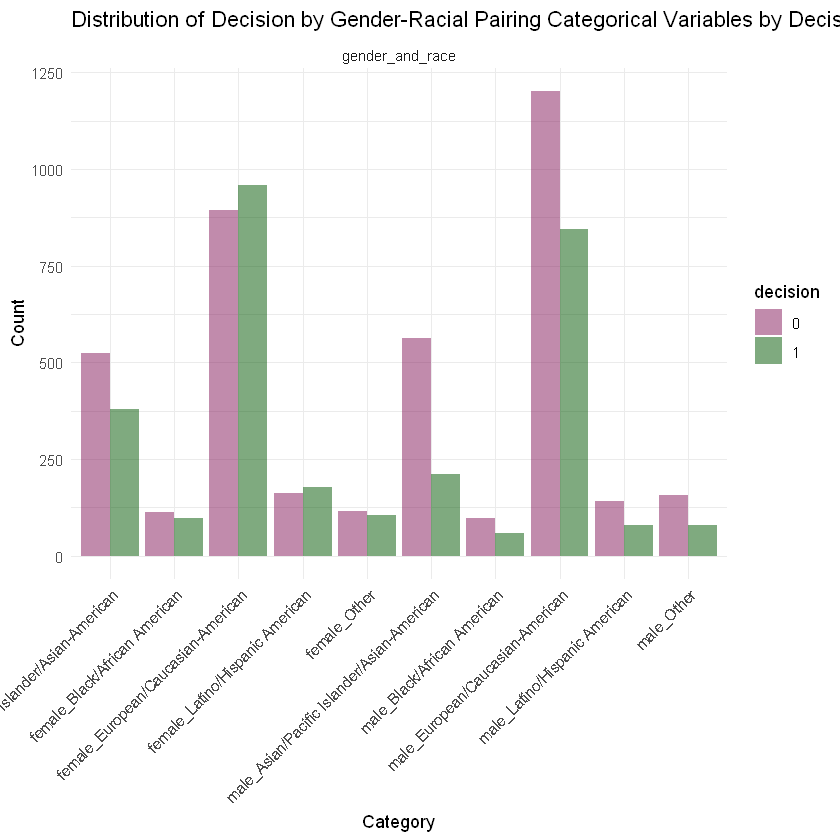

In [25]:
df_dating |>
    mutate(samerace = as.character(samerace)) |> 
    unite(
        col = "gender_and_race",
        c("gender", "race"),
        sep = "_"
    ) |>
    plot_categorical_distributions(
        cat_vars = "gender_and_race",
        fill_var = "decision",
        plot_title = "Decision by Gender-Racial Pairing"
    )

# Correlations

## Feature Correlation Heatmaps

In [29]:
plot_heatmap <- function(feat_subset,subset_name, data = df_dating, custom_matrix = NULL) {
    if (is.null(custom_matrix) ) {
    corr_mat <- cor(data[feat_subset]) |> 
        round(digits = 4) |> 
        as.data.frame() |>
        rownames_to_column("Variable1")
    }
    else {
        corr_mat <- custom_matrix
    }
    cor_long <- corr_mat |>
        pivot_longer(
            cols = -Variable1,        
            names_to = "Variable2",   
            values_to = "Correlation" 
        )

    ggplot(cor_long, aes(x = Variable1, y = Variable2, fill = Correlation)) +
        geom_tile(color = "white", size = 0.8) +
        #geom_text(aes(label = round(Correlation, 2)), color = "black", size = 4) +
        scale_fill_gradient2(
            low = class_colors_grad[1],
            midpoint = 0,
            high = class_colors_grad[10]) +
        labs(
            title = paste("Correlation Heatmap between",subset_name,"Features"),
            x = "",
            y = ""
        ) +
        theme_minimal() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

In [30]:
extract_outcome_cor_mat <- function (data=df_dating){
    decision_as_num <- data$decision |> as.numeric()
    data_numeric <- data[sapply(data, is.numeric)]
    cor_mat <- cor(data_numeric,decision_as_num) |>
        round(digits = 4) |> 
        as.data.frame() |>
        rownames_to_column("Variable1")
    return(cor_mat)
}

### Numeric Versus Decision Outcome

In [31]:
outcome_cor_mat <- extract_outcome_cor_mat(df_dating) 
cor_threshold = 0.1
cor_mat_thres <- outcome_cor_mat[outcome_cor_mat[2] >= cor_threshold | outcome_cor_mat[2] <= -cor_threshold,] |> arrange(desc(V1))
cor_mat_thres

Variable1,V1
<chr>,<dbl>
attractive_o,0.4869
funny_o,0.4114
shared_interests_o,0.3987
intelligence_o,0.2134
sinsere_o,0.2070
ambitous_o,0.1826


### By Subject Characteristics

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


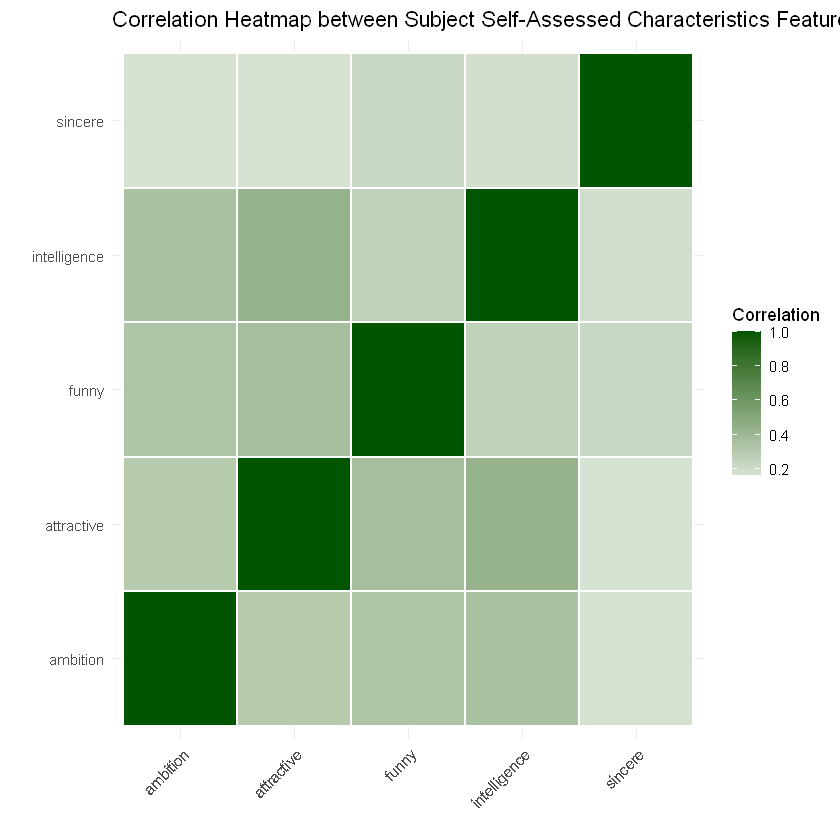

In [32]:
plot_heatmap(subject_self_ratings,"Subject Self-Assessed Characteristics")

### By Partner Characteristics

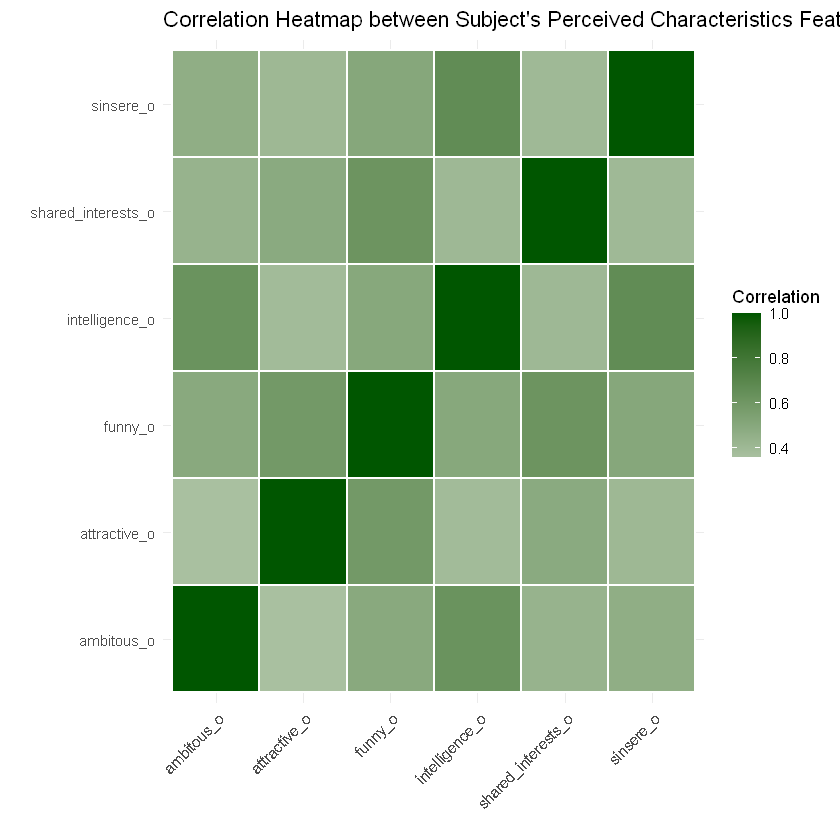

In [33]:
plot_heatmap(partner_self_ratings,"Subject's Perceived Characteristics")

### By Subject Interests

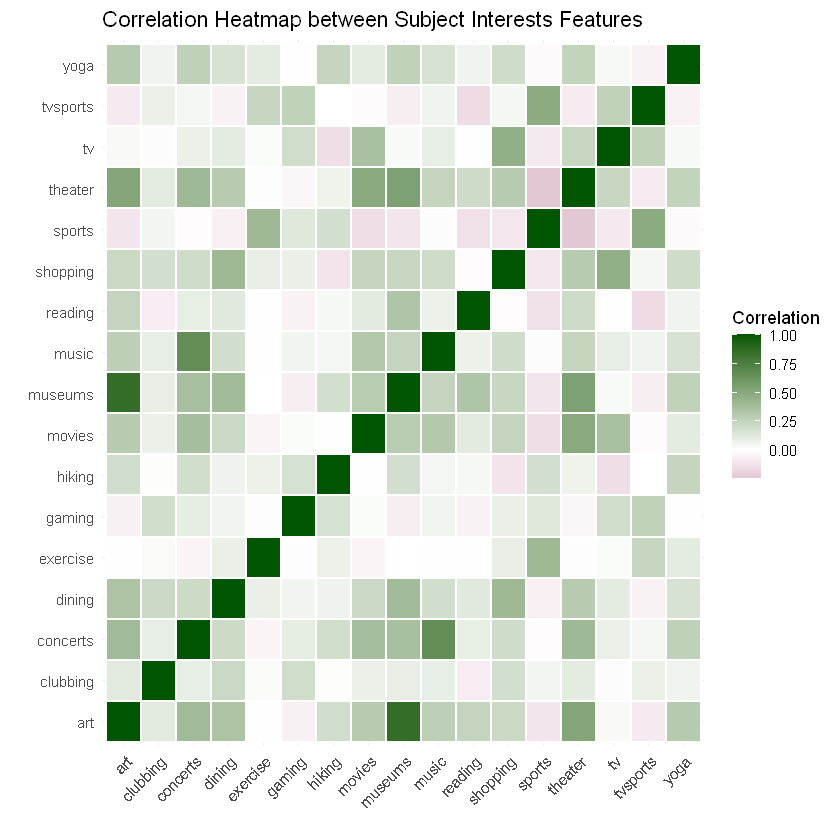

In [34]:
plot_heatmap(interests,"Subject Interests")

# Cluster Discovery

In [35]:
plot_pca <- function(data){
    numeric_data <- data[sapply(data, is.numeric)]
    pca_results <- prcomp(numeric_data, scale = TRUE)
    pca_data <- data.frame(
        PC1 = pca_results$x[, 1],
        PC2 = pca_results$x[, 2],
        decision = data$decision
    )
    ggplot(pca_data, aes(x = PC1, y = PC2, color = decision)) +
        geom_point(size = 3, alpha = 0.3) +
        labs(
            title = "PCA of Numerical Features",
            subtitle = "Points colored by 'Decision'",
            x = paste("PC1 (", round(summary(pca_results)$importance[2, 1] * 100), "%)"),
            y = paste("PC2 (", round(summary(pca_results)$importance[2, 2] * 100), "%)"),
            color = "Decision"
        ) +
        theme_minimal(base_size = 15) +
        scale_color_manual(values = class_colors)
}

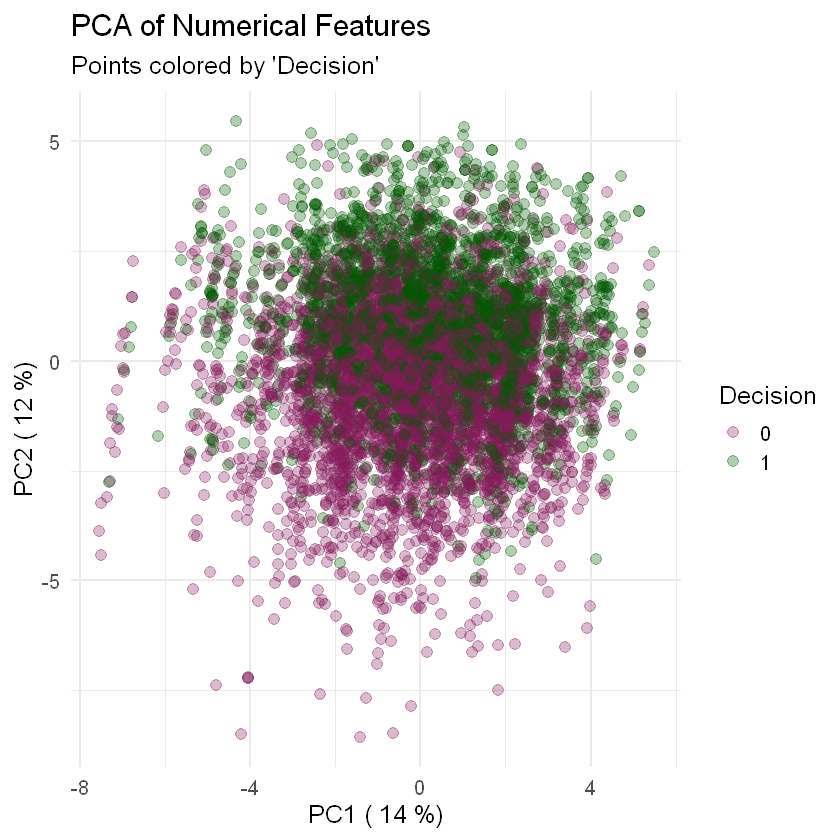

In [36]:
plot_pca(df_dating)

In [ ]:

plot_tsne <- function(data){
    unique_data <- unique(data)

    numeric_data <- unique_data |>
        select(where(is.numeric)) |> unique()

    outcome_data <- unique_data |>
        select(decision)
    # Run t-SNE on your numerical data
    tsne_results <- Rtsne(numeric_data, dims = 2, perplexity = 5, verbose = FALSE)

    # Create a plot of the results
    plot_tsne_data <- data.frame(
        TSNE1 = tsne_results$Y[, 1],
        TSNE2 = tsne_results$Y[, 2],
        decision = outcome_data
    )

    ggplot(plot_tsne_data, aes(x = TSNE1, y = TSNE2, color = decision)) +
        geom_point(alpha = 0.5) +
        theme_minimal(base_size = 15) +
        scale_color_manual(values = class_colors) + 
        labs(title = "tSNE Dimensionality Reduced Clustering")
}
#plot_tsne(df_dating)

ERROR: Error in data.frame(TSNE1 = tsne_results$Y[, 1], TSNE2 = tsne_results$Y[, : arguments imply differing number of rows: 6942, 6945
